In [62]:
## Importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from chart_studio.plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go  
#offline.init_notebook_mode()
from collections import Counter

In [ ]:
# !pip install tensorflow==1.15.0
# !pip install keras==2.3.1
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/processed_data_split.h2' '/content/'
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/model_inputs_labelencode.pkl' '/content/'
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/model_input_cat_lables.pkl' '/content/'
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/tuning_output.pkl' '/content/'
# !cp -r  '/content/drive/My Drive/_datasets/glove_vectors' '/content/'

### Load all the preprocessed data required for model2  created in Model1

In [ ]:
## Load data after split
x_train = pd.read_hdf('processed_data_split.h2', 'x_train',mode='r')
x_test = pd.read_hdf('processed_data_split.h2', 'x_test',mode='r') 
x_cv = pd.read_hdf('processed_data_split.h2', 'x_cv',mode='r')
y_train =pd.read_hdf('processed_data_split.h2', 'y_train',mode='r')
y_test =pd.read_hdf('processed_data_split.h2', 'y_test',mode='r')
y_cv =pd.read_hdf('processed_data_split.h2', 'y_cv',mode='r')
print('*'*50)
print(' Successfully loaded processed split data')
emd_i,embedding_matrix,seq_x_train,seq_x_test,seq_x_cv,padseq_x_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,teacher_prefix_train,numerical_train,padseq_x_test,sklstate_test,proj_grade_test,test_categories,test_subcategories,teacher_prefix_test,numerical_test,padseq_x_cv,sklstate_cv,proj_grade_cv,cv_categories,cv_subcategories,teacher_prefix_cv,numerical_cv = pickle.load(open('model_inputs_labelencode.pkl','rb'))
print('*'*50)
print(' Successfully loaded model input variables')
y_train_cat,y_test_cat,y_cv_cat = pickle.load(open('model_input_cat_lables.pkl', 'rb'))
print('*'*50)
print('Successfully loaded split y labels')

**************************************************
 Successfully loaded processed split data
**************************************************
 Successfully loaded model input variables
**************************************************
Successfully loaded split y labels


#### Model-2

Build and Train deep neural network as shown below

<pre>
Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

#### 2.1 Remove less important  words from preprocessed essay 



length of essay dictionary is :  47226


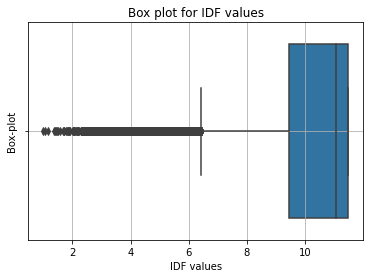

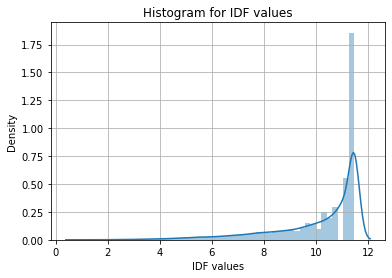

100%|██████████| 47226/47226 [00:00<00:00, 942063.71it/s]



Idf values in IQR range:  [ 9.44704251 11.46194553]


In [ ]:
tfidf_text = TfidfVectorizer(lowercase=True)
tfidf_text.fit(x_train['preprocessed_essay'].values)

## get features with its idf_values
essay_dictionary = dict(zip(set(tfidf_text.get_feature_names() ),tfidf_text.idf_))
essay_words = essay_dictionary.keys()

print('\n')
print('length of essay dictionary is : ',len(essay_words))



# plot box plot 
sns.boxplot(tfidf_text.idf_)
plt.xlabel('IDF values')
plt.ylabel('Box-plot')
plt.title('Box plot for IDF values')
plt.grid()
plt.show() 


#histogram of  IDF values
sns.distplot(tfidf_text.idf_)
plt.xlabel('IDF values')
plt.title('Histogram for IDF values')
plt.grid()
plt.show() 
'''We are going to remove all the word indexs/sequence number which are having idf value less than 25th percentile
and greater than 75th percentile '''

print('\n')
print('Idf values in IQR range: ',np.percentile(tfidf_text.idf_,[25,75]))

remove_words = []
percentile = np.percentile(tfidf_text.idf_,[25,75])
for k,v in tqdm(essay_dictionary.items()):
    if v < 6 or v > percentile[1] : 
            remove_words.append(k)

def filter_words(text,remove_words):
    filtered_essay = []
    for sentence in tqdm(text):
            filtered_sentence=''
            filtered_sentence = ' '.join(w  for w in sentence.split() if w not in remove_words)            
            filtered_essay.append(filtered_sentence)   
    return filtered_essay



##### Note : We are considering words which fall in the range from 6 - 11.46194553(i.e 75th percentile ) because we observe good number of  points in that region.There are 0 words which are below 2 and many points fall above 11 .If we neglect points above 11 we loose half the words .

In [ ]:
filtered_essay_train = filter_words(x_train['preprocessed_essay'].values,remove_words)
filtered_essay_test = filter_words(x_test['preprocessed_essay'].values,remove_words) 
filtered_essay_cv = filter_words(x_cv['preprocessed_essay'].values,remove_words)     


100%|██████████| 17480/17480 [01:29<00:00, 195.38it/s]


In [ ]:
print('\nLength of sample datapoint without filtering is ',
          len(x_train['preprocessed_essay'].values[0]),' ',
        ' and with filtering is: ',len(filtered_essay_train[0])) 


Length of sample datapoint without filtering is  733    and with filtering is:  720


In [ ]:
## convert essay to sequences
'''The essay is in textual format ,we need to convert to sequences of index and pad them'''
from keras.preprocessing.text import Tokenizer
tok = Tokenizer()
tok.fit_on_texts(filtered_essay_train)
seq_x_train = tok.texts_to_sequences(filtered_essay_train)
seq_x_test = tok.texts_to_sequences(filtered_essay_test)
seq_x_cv = tok.texts_to_sequences(filtered_essay_cv)
vocab_size = len(tok.word_index) + 1

In [ ]:
## lets pad the sequenced essay
'''After indexing the essay lets padd them using post padding '''
from keras.preprocessing import sequence
max_review_length = 300 
padfiltered_sequence_train = sequence.pad_sequences(seq_x_train,maxlen=max_review_length,padding='post') 
padfiltered_sequence_test = sequence.pad_sequences(seq_x_test,maxlen=max_review_length,padding='post') 
padfiltered_sequence_cv = sequence.pad_sequences(seq_x_cv,maxlen=max_review_length,padding='post') 

In [ ]:
print('Train data after padding and sequencing')
print('*'*50)
print(padfiltered_sequence_train[1],len(padfiltered_sequence_train[1]))

Train data after padding and sequencing
**************************************************
[   1  201  192  473 1216  185   43   16    1   11   52    1  295  367
  827  703   31  185  170   70   60  144  324   63  131    1  201 1527
 1558  977 6338 4238  114    3    1   11  671 4115  129   29    6  249
   51  205   83  324  134   29    3  522 1569  422  134  114    1  833
   52  249   51    1   10   73  700  473  862  473 1982   99  700  848
  473  140 1453 3108  189 3040  942  151  153  205   83  151  205  144
  168  424   87  386 1163    7 1605    1  540  256  205   83   62    1
  414   63 2092  405    8    9    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  

In [ ]:
'''using glove vectors lets create a embedding matrix such that for every word 
  in vocabulary we store its corresponding glove vector in matrix form'''
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)   

In [ ]:
import numpy as np
#embedd_matrix = np.zeros((vocab_len,max_review_length)) 
glove_words = model.keys()
emd_i =dict()

## lets create a dictionary that stores the 300 dim glove vector as value and the word's index as key 
for i,w in tok.index_word.items():
    #if w in glove_words:
    emd_i[i] = model.get(w)
    #else:  emd_i[i] = np.zeros((1,max_review_length))
    
## emd_matrix stores all the 300 dimensional glove vectors of words based on their rank from  the tokenizer.
## the most frequent  word is given the highest rank   

# emd_matrix = np.zeros((vocab_len,max_review_length))
# print(emd_matrix.shape)
# for i in range(1,vocab_len+1):
#     emd_matrix[i-1] = emd_i[i]  

# create a weight matrix for words in training docs
print('Loaded %s word vectors.' % len(emd_i))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tok.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 45161 word vectors.


In [ ]:
print('shape of embedding matrix = ',embedding_matrix.shape)

shape of embedding matrix =  (45162, 300)


In [ ]:
if  os.path.isfile('model2_inputs.pkl') : 
    os.remove("model2_inputs.pkl")
    print("File model_inputs Removed!")
with open('model2_inputs.pkl', 'wb') as f: 
    pickle.dump([emd_i,embedding_matrix,seq_x_train,seq_x_test,seq_x_cv,
                 padfiltered_sequence_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,
    teacher_prefix_train,numerical_train,
    padfiltered_sequence_test,sklstate_test,proj_grade_test,test_categories,test_subcategories,
    teacher_prefix_test,numerical_test,
    padfiltered_sequence_cv,sklstate_cv,proj_grade_cv,cv_categories,cv_subcategories,
    teacher_prefix_cv,numerical_cv],f)

File model_inputs Removed!


In [ ]:
! cp -r     '/content/drive/My Drive/LSTM_preprocessed/model2/model2_inputs.pkl'  '/content/'

In [ ]:
emd_i,embedding_matrix,seq_x_train,seq_x_test,seq_x_cv,padfiltered_sequence_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,teacher_prefix_train,numerical_train, padfiltered_sequence_test,sklstate_test,proj_grade_test,test_categories,test_subcategories,teacher_prefix_test,numerical_test,padfiltered_sequence_cv,sklstate_cv,proj_grade_cv,cv_categories,cv_subcategories,teacher_prefix_cv,numerical_cv = pickle.load(open('model2_inputs.pkl','rb'))

In [ ]:
vocab_size = len(embedding_matrix)

In [ ]:
len(list(filter(lambda x : x <6 or x>percentile[1],essay_dictionary.values())))

428

### Hyperparameter Tuning


In [ ]:
import tensorflow as tf
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.regularizers import l2 
import keras
import keras.backend as k
from tensorflow import set_random_seed
from sklearn.metrics import roc_auc_score

from keras.layers import Dropout,Input,Activation,Dense,Embedding,concatenate,LSTM,Flatten,BatchNormalization,LeakyReLU
from keras.models import Model
def aucroc(y_true,y_pred):
    try:
        return  tf.py_func(roc_auc_score,(y_true, y_pred),tf.double)
    except ValueError:
        pass


2709

In [ ]:
len(remove_words)

2093

In [ ]:
set_random_seed(2)
## clear the graph of the tensorflow
k.clear_session()
### defining all the Input layer 
#set_random_seed(2)
input_seq_total_text_data = Input(shape=padfiltered_sequence_train[0].shape,name='text_Input')
input_school_state = Input(shape=(1,),name='school_state_Input')
input_project_grade_category = Input(shape=(1,),name='project_grade_category_Input')
input_clean_categories = Input(shape=(1,),name='input_clean_categories_Input')
input_clean_subcategories = Input(shape=(1,),name='input_clean_subcategories_Input')
input_teacher_prefix = Input(shape=(1,),name='input_teacher_prefix')
input_numerical = Input(shape=(numerical_train.shape[1],),name='input_numerical')

auc_scores_model2 = []
if (not os.path.isfile('tuning_output2.pkl')):   
    for embedding_index in [32,64,128]:
        for lstm_index in [32,64,128]:
            for num_dense_index in [128,64,32]:
                
                ## Define embedding layers for all inputs
                embedding_layer_text = Embedding(input_dim=vocab_size,output_dim=300,weights = [embedding_matrix]
                                                ,trainable=False)(input_seq_total_text_data) 
                embedding_layer_school_state = Embedding(input_dim=1,output_dim=embedding_index,
                                                                input_length=1)(input_school_state)
                embedding_layer_project_grade_category = Embedding(input_dim=1,output_dim=embedding_index,
                                                                input_length=1)(input_project_grade_category)
                embedding_layer_clean_categories = Embedding(input_dim=1,output_dim=embedding_index,
                                                                input_length=1)(input_clean_categories)
                embedding_layer_clean_subcategories = Embedding(input_dim=1,output_dim=embedding_index,
                                                                input_length=1)(input_clean_subcategories)
                embedding_layer_teacher_prefix = Embedding(input_dim=1,output_dim=embedding_index,
                                                                input_length=1)(input_teacher_prefix)

                ### Define LSTM for the text
                '''Return sequences = True ensure output from all theLSTM is returned not just the final output from last LSTM'''
                lstm_layer_text = LSTM(lstm_index,return_sequences=True)(embedding_layer_text)

                ### Define flatten layer and Dense layer for numerical input
                flatten_text = Flatten()(lstm_layer_text)
                flatten_school_state = Flatten()(embedding_layer_school_state)
                flatten_project_grade_category = Flatten()(embedding_layer_project_grade_category)
                flatten_clean_categories = Flatten()(embedding_layer_clean_categories)
                flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)
                flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)
                rem_input_dense = Dense(num_dense_index,activation='relu',kernel_initializer='he_normal')(input_numerical)

                ##Concatenate all the layers
                concat_layer = concatenate([flatten_text,flatten_school_state,flatten_project_grade_category,flatten_clean_categories,
                                            flatten_clean_subcategories,flatten_teacher_prefix,rem_input_dense])

                ##define three dense layers with dropout
                dense1_layer = Dense(256,activation='relu',kernel_initializer='he_normal')(concat_layer)
                regularization_layer1 = BatchNormalization()(dense1_layer)
                regularization_layer1 = Dropout(0.35)(regularization_layer1)
                dense2_layer = Dense(128,activation='relu',kernel_initializer='he_normal')(regularization_layer1)
                regularization_layer2 = BatchNormalization()(dense2_layer)
                regularization_layer2 = Dropout(0.35)(regularization_layer2)
                dense3_layer = Dense(64,activation='relu',kernel_initializer='he_normal')(regularization_layer2)
                regularization_layer2 = BatchNormalization()(dense3_layer)
                #regularization_layer2 = Dropout(0.25)(regularization_layer2)
                output_layer = Dense(2,activation='sigmoid',kernel_initializer='glorot_normal',activity_regularizer=l2(0.0001))(regularization_layer2)

                model2 = Model(inputs=[input_seq_total_text_data,
                                      input_school_state,input_project_grade_category,
                                      input_clean_categories,input_clean_subcategories,
                                      input_teacher_prefix,input_numerical],outputs=output_layer)

                ## Compile the model2 with default learning rate
                model2.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy',aucroc])
                callback = tf.keras.callbacks.EarlyStopping(monitor='val_aucroc',verbose=1, patience=3,restore_best_weights=True,mode='max')
                history = model2.fit([padfiltered_sequence_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,
                                     teacher_prefix_train,numerical_train],y_train_cat,epochs=10,batch_size=1000,verbose=1,
                                    validation_data=[[padfiltered_sequence_cv,sklstate_cv,proj_grade_cv,cv_categories,
                                                      cv_subcategories,teacher_prefix_cv,numerical_cv],y_cv_cat],
                                     callbacks=[callback])
                max_= np.argmax(history.history['val_aucroc'])
                print('Validation loss for embedding units={0}, lstm layer={1} ,numerical dense units={2} '.format(embedding_index,lstm_index,num_dense_index),
                      ' is :' ,history.history['val_loss'][max_])
                
                auc_scores_model2.append((embedding_index,lstm_index,num_dense_index,history.history['accuracy'][max_]
                                   ,history.history['loss'][max_],history.history['aucroc'][max_],
                                   history.history['val_accuracy'][max_],history.history['val_loss'][max_],history.history['val_aucroc'][max_]))
    
    df = pd.DataFrame(data=auc_scores_model2,columns=['Embedding units','LSTM units','Dense numerical units',
                                               'Train Accuracy','Train Loss','Train auc','Test Accuracy','Test Loss','Test auc'])
    best_param = df[df['Test auc'] == df['Test auc'].max()]
    with open('tuning_output2.pkl', 'wb') as f:
        pickle.dump([df,auc_scores_model2,best_param] , f)

else:
    df,auc_scores_model2,best_param = pickle.load(open('tuning_output2.pkl','rb'))
    print('----Tuning output loaded -------')

Train on 69918 samples, validate on 17480 samples
Epoch 1/10
69918/69918 [==============================] - 33s 469us/step - loss: 0.5453 - accuracy: 0.7232 - aucroc: 0.5217 - val_loss: 0.4428 - val_accuracy: 0.8223 - val_aucroc: 0.5070
Epoch 2/10
69918/69918 [==============================] - 31s 449us/step - loss: 0.4392 - accuracy: 0.8055 - aucroc: 0.5285 - val_loss: 0.4254 - val_accuracy: 0.8329 - val_aucroc: 0.5897
Epoch 3/10
69918/69918 [==============================] - 32s 452us/step - loss: 0.4055 - accuracy: 0.8329 - aucroc: 0.5425 - val_loss: 0.4174 - val_accuracy: 0.8527 - val_aucroc: 0.5798
Epoch 4/10
69918/69918 [==============================] - 31s 450us/step - loss: 0.3798 - accuracy: 0.8519 - aucroc: 0.5604 - val_loss: 0.4029 - val_accuracy: 0.8506 - val_aucroc: 0.6200
Epoch 5/10
69918/69918 [==============================] - 32s 451us/step - loss: 0.3597 - accuracy: 0.8600 - aucroc: 0.5923 - val_loss: 0.3878 - val_accuracy: 0.8543 - val_aucroc: 0.6257
Epoch 6/10
6991

In [ ]:
df = pd.DataFrame(data=auc_scores_model2,columns=['Embedding units','LSTM units','Dense numerical units',
                                           'Train Accuracy','Train Loss','Train auc','Test Accuracy','Test Loss','Test auc'])

In [ ]:
df.tail(10)

,Embedding units,LSTM units,Dense numerical units,Train Accuracy,Train Loss,Train auc,Test Accuracy,Test Loss,Test auc
17,64,128,32,0.856217,0.299048,0.767236,0.821568,0.470457,0.681503
18,128,32,128,0.847707,0.341145,0.724302,0.830263,0.400753,0.706534
19,128,32,64,0.839011,0.358630,0.680320,0.822140,0.401445,0.699575
20,128,32,32,0.855002,0.356793,0.647431,0.843936,0.382278,0.704629
21,128,64,128,0.884365,0.254372,0.834121,0.825572,0.523246,0.694111
22,128,64,64,0.887482,0.278534,0.789397,0.843936,0.413120,0.696618
23,128,64,32,0.829257,0.366427,0.683132,0.815389,0.411847,0.648535
24,128,128,128,0.860394,0.347377,0.682235,0.848856,0.385847,0.684885
25,128,128,64,0.854901,0.362602,0.623140,0.807838,0.434367,0.617782
26,128,128,32,0.845762,0.379724,0.614951,0.845137,0.383634,0.658889


#### Best Hyperparameter values

In [ ]:
best_param = df[df['Test auc'] == df['Test auc'].max()]

In [ ]:
best_param

,Embedding units,LSTM units,Dense numerical units,Train Accuracy,Train Loss,Train auc,Test Accuracy,Test Loss,Test auc
9,64,32,128,0.853214,0.334687,0.734609,0.797483,0.440253,0.713029


### Train the Model with best hyperparameters

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime, os
#%reload_ext tensorboard

In [81]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# Clear any logs from previous runs
!rm -rf ./logs/ 
#set_random_seed(65)
## clear the graph of the tensorflow
tf.keras.backend.clear_session()
### defining all the Input layer        
input_seq_total_text_data = Input(shape=padfiltered_sequence_train[0].shape,name='text_Input')
input_school_state = Input(shape=(1,),name='school_state_Input')
input_project_grade_category = Input(shape=(1,),name='project_grade_category_Input')
input_clean_categories = Input(shape=(1,),name='input_clean_categories_Input')
input_clean_subcategories = Input(shape=(1,),name='input_clean_subcategories_Input')
input_teacher_prefix = Input(shape=(1,),name='input_teacher_prefix')
input_numerical = Input(shape=(numerical_train.shape[1],),name='input_numerical')

## Define embedding layers for all inputs
embedding_layer_text = Embedding(input_dim=vocab_size,output_dim=300,weights = [embedding_matrix],trainable=False)(input_seq_total_text_data) 
embedding_layer_school_state = Embedding(input_dim=1,output_dim=int(best_param['Embedding units']))(input_school_state)
embedding_layer_project_grade_category = Embedding(input_dim=1,output_dim=int(best_param['Embedding units']))(input_project_grade_category)
embedding_layer_clean_categories = Embedding(input_dim=1,output_dim=int(best_param['Embedding units']))(input_clean_categories)
embedding_layer_clean_subcategories = Embedding(input_dim=1,output_dim=int(best_param['Embedding units']))(input_clean_subcategories)
embedding_layer_teacher_prefix = Embedding(input_dim=1,output_dim=int(best_param['Embedding units']))(input_teacher_prefix)

### Define LSTM for the text
'''Return sequences = True ensure output from all theLSTM is returned not just the final output from last LSTM'''
lstm_layer_text = LSTM(int(best_param['LSTM units']),return_sequences=True)(embedding_layer_text)

### Define flatten layer and Dense layer for numerical input
flatten_text = Flatten()(lstm_layer_text)
flatten_school_state = Flatten()(embedding_layer_school_state)
flatten_project_grade_category = Flatten()(embedding_layer_project_grade_category)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)
flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)
flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)
rem_input_dense = Dense(int(best_param['Dense numerical units']),activation='relu',kernel_initializer='he_normal')(input_numerical)

##Concatenate all the layers
concat_layer = concatenate([flatten_text,flatten_school_state,flatten_project_grade_category,flatten_clean_categories,
                          flatten_clean_subcategories,flatten_teacher_prefix,rem_input_dense])

##define three dense layers with dropout
dense1_layer = Dense(512,kernel_initializer='he_normal')(concat_layer)
activation = LeakyReLU(0.3)(dense1_layer) 
regularization_layer1 = BatchNormalization()(activation)
regularization_layer1 = Dropout(0.25)(regularization_layer1)
dense2_layer = Dense(256,kernel_initializer='he_normal')(regularization_layer1)
activation = LeakyReLU(0.3)(dense2_layer) 
regularization_layer2 = BatchNormalization()(activation)
regularization_layer2 = Dropout(0.25)(regularization_layer2)
dense3_layer = Dense(128,kernel_initializer='he_normal')(regularization_layer2)
activation = LeakyReLU(0.3)(dense3_layer) 
regularization_layer2 = BatchNormalization()(activation)
regularization_layer2 = Dropout(0.25)(regularization_layer2)
dense4_layer = Dense(64,kernel_initializer='he_normal')(regularization_layer2)
activation = LeakyReLU(0.3)(dense4_layer) 
regularization_layer2 = BatchNormalization()(activation)
regularization_layer2 = Dropout(0.25)(regularization_layer2)
dense5_layer = Dense(32,kernel_initializer='he_normal')(regularization_layer2)
activation = LeakyReLU(0.3)(dense5_layer)
regularization_layer2 = BatchNormalization()(activation)
regularization_layer2 = Dropout(0.25)(regularization_layer2)
output_layer = Dense(2,activation='sigmoid',kernel_initializer='glorot_normal',activity_regularizer=l2(0.002))(regularization_layer2)

if not os.path.isfile('best_model2_output.pkl'):
    model2 = Model(inputs=[input_seq_total_text_data,
                        input_school_state,input_project_grade_category,
                        input_clean_categories,input_clean_subcategories,
                        input_teacher_prefix,input_numerical],outputs=output_layer)

    model2.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy',aucroc])

    log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0, write_graph=True,write_grads=True)

    ## early stopping 
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau 
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_aucroc',verbose=1, patience=5,restore_best_weights=True,mode='max')
    mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_aucroc', mode='max')
    reduce_lr_2 = ReduceLROnPlateau(monitor='val_aucroc', factor=0.2,patience=2, min_lr=0.001,verbose = 1,mode='max')
    history = model2.fit([padfiltered_sequence_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,
                        teacher_prefix_train,numerical_train],y_train_cat,epochs=25,batch_size=1000,verbose=1,
                      validation_data=[[padfiltered_sequence_cv,sklstate_cv,proj_grade_cv,cv_categories,
                                        cv_subcategories,teacher_prefix_cv,numerical_cv],y_cv_cat],
                          callbacks=[tensorboard_callback,mcp_save,reduce_lr_2])
    hist = history.history
    with open('best_model2_output.pkl','wb') as f:
        pickle.dump(hist, f)
        
else:
    hist = pickle.load(open('best_model2_output.pkl', 'rb'))
    print('----Model output loaded after tuning-------')

Train on 69918 samples, validate on 17480 samples
Epoch 1/25
69918/69918 [==============================] - 34s 482us/step - loss: 1.3797 - accuracy: 0.6720 - aucroc: 0.5325 - val_loss: 0.8318 - val_accuracy: 0.7878 - val_aucroc: 0.5649
Epoch 2/25
69918/69918 [==============================] - 32s 454us/step - loss: 0.8419 - accuracy: 0.7996 - aucroc: 0.5616 - val_loss: 0.5848 - val_accuracy: 0.8241 - val_aucroc: 0.5866
Epoch 3/25
69918/69918 [==============================] - 32s 455us/step - loss: 0.6147 - accuracy: 0.8281 - aucroc: 0.5901 - val_loss: 2.6651 - val_accuracy: 0.4086 - val_aucroc: 0.5214
Epoch 4/25
69918/69918 [==============================] - 32s 454us/step - loss: 0.5097 - accuracy: 0.8377 - aucroc: 0.6168 - val_loss: 1.2313 - val_accuracy: 0.6902 - val_aucroc: 0.5383

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 5/25
69918/69918 [==============================] - 32s 454us/step - loss: 0.4540 - accuracy: 0.8460 - aucroc: 0.6333 - val_loss: 2

## Confusion Matrix and ROC Plot


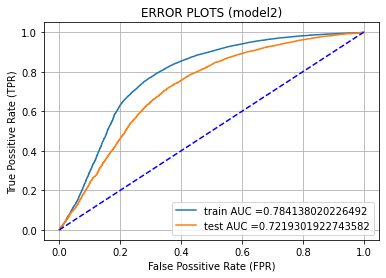

the maximum value of tpr*(1-fpr) 0.5414291582816169 for threshold 0.038


In [83]:
from sklearn.metrics import confusion_matrix
## Finding best threshold for predictions
def best_threshold(thresholds,fpr,tpr):
    t=thresholds[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



## Predict the test and train 
model2.load_weights('mdl_wts.hdf5')
y_test_predict = model2.predict([padfiltered_sequence_test ,sklstate_test,proj_grade_test,test_categories,test_subcategories,
                        teacher_prefix_test,numerical_test],use_multiprocessing=True)[:,1]
y_train_predict = model2.predict([padfiltered_sequence_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,
                        teacher_prefix_train,numerical_train],use_multiprocessing=True)[:,1]

if  os.path.isfile('model_predictions.pkl'):
    os.remove('model_predictions.pkl')
    print("File model_predictions Removed!")
    with open('model_predictions.pkl','wb') as f:
        pickle.dump([y_train_predict,y_test_predict],f)
        
## Store fpr and tpr rates 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_predict) 


#plot
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Possitive Rate (FPR)")
plt.ylabel("True Possitive Rate (TPR)")
plt.title("ERROR PLOTS (model2)")
plt.plot([0, 1], [0, 1],'b--')
plt.grid()
plt.show()

print("="*100)

best_t=best_threshold(tr_thresholds,train_fpr, train_tpr)


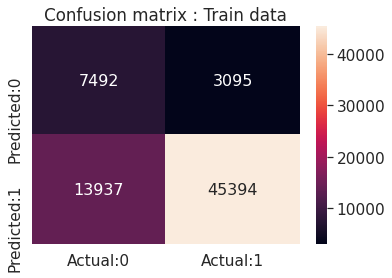

In [85]:
### PLOT the matrix for Train
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
# source : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
df_cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_predict, best_t))
                     , range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',
            xticklabels=['Actual:0','Actual:1']
           ,yticklabels=['Predicted:0','Predicted:1']) # font size
plt.title('Confusion matrix : Train data')
plt.show()    

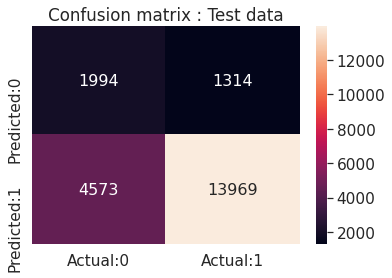

In [86]:
### PLOT the matrix for Test
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
# source : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_predict, best_t))
                     , range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',
            xticklabels=['Actual:0','Actual:1']
           ,yticklabels=['Predicted:0','Predicted:1']) # font size
plt.title('Confusion matrix : Test data')
plt.show()    

<li><b>Validation Loss,Validation aucroc,Train Loss,Train aucroc</b>
<img src='model2.jpg' width="800" height="800">

### Model2 Summary :
    * Preprocesed and vectorized the input variables along with label encoding categorical data.
    * Unlike model1 we reduce the number of words from our text input using the word's IDF values.
    * While choosing only words within the IQR range model doesn't seem to perform well as model 1 as we are loosing many words.
    * While choosing words within idf range 2-11 , just a negligible amount of words are removed, which is same as Model1.
    * Hence a reasonable range of 6-11.46(i.e 75th percentile ) is chosen here .
    * We Tuned our model with various embedding input dimensions,dense numerical units and LSTM units with early stopping techniques and found the best combination with highest Test auc values .

    * After finding the best combination we tuned our best model with this combination increasing the number of layers,
      dropout and batch normalization layers,including Leaky relu activation and activity regularizers to imporve the model performance

    * Used keras callback methods to perform early stopping,reduce learning rate,model checkpoints to monitor our model
      to attain maximum validation auc.
     
    * We see that as the number of epochs goes above 14 our Validation auc reduces and loss increases drastically.Hence we save the model at the best epoch.
    
    * When we plot FPR against TPR our model gives 0.78 as train auc and 0.72 as test auc performing better than model1 with lesser number of words in text input 
        